# BiLSTM for forecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor

np.random.seed(0)
if torch.cuda.is_available():  
    dev = "cuda:0" 
    torch.cuda.manual_seed(0)
else:  
    dev = "cpu"
    torch.manual_seed(0)
device = torch.device(dev)

## load data

In [16]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')
data.index = pd.to_datetime(data.index)

## normalization

In [4]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [5]:
def series_to_supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + target_len, -1]
    print("supervised data: shape of x: {}, shape of y: {}".format(x.shape, y.shape))
    return x, y

## 5-folds TimeSeriesSplit

In [6]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## BiLSTM model

In [7]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,
                 drop_prob):
        super(BiLSTM, self).__init__()
        # model parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_size = output_size
        # layes
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=drop_prob,
                            bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(hidden_dim * 2, 30), nn.ReLU(),
                                nn.Linear(30, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -self.output_size:, :]

        out = self.fc(lstm_out)
        out = self.relu(out)

        out = out.view(batch_size, -1)

        return out

    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.n_layers*2, batch_size,
                              self.hidden_dim).to(device),
                  torch.zeros(self.n_layers*2, batch_size,
                              self.hidden_dim).to(device))
        return hidden

## model training for HPO

In [8]:
def train_model_hpo(train_x_list, train_y_list, valid_x_list, valid_y_list,
                    input_size, output_size, mse_thresh, batch_size, lr,
                    number_epoch, hidden_dim, n_layers, drop_prob, weight_decay):
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model = BiLSTM(input_size, output_size, hidden_dim, n_layers,
                           drop_prob)
            model.to(device=device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
            valid_loss_min = np.Inf
            print('cross-validation dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))
            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            num_without_imp = 0
            # training process
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True)
                for i, (inputs, labels) in loop:
                    inputs = inputs.to(device=device)
                    labels = labels.to(device=device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    if i % 5 == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            out = model(inp)
                            valid_loss = criterion(out, lab)
                            valid_losses.append(valid_loss.item())

                        model.train()
                        loop.set_description("Epoch: {}/{}".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                scheduler.step()
                if num_without_imp >= 50:
                    break
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [88]:
seq_len = 72
target_len = 24
mse_thresh = 0.05


def model_config():
    batch_sizes = [512, 256]
    lrs = [0.01]
    number_epochs = [50]
    hidden_dims = [150, 120, 100, 80]
    n_layers = [1, 2, 3]
    drop_prob = [0]
    weight_decays = [0]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in hidden_dims:
                    for m in n_layers:
                        for n in drop_prob:
                            for o in weight_decays:
                                configs.append({
                                    'batch_size': i,
                                    'lr': j,
                                    'number_epoch': k,
                                    'hidden_dim': l,
                                    'n_layers': m,
                                    'drop_prob': n,
                                    'weight_decay': o,
                                })
    return configs

## random search for HPO

In [89]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
    #     with enough data
    #     train_x_list = train_x_list[-1:]
    #     train_y_list = train_y_list[-1:]
    #     valid_x_list = valid_x_list[-1:]
    #     valid_y_list = valid_y_list[-1:]

    configs = model_config()
    records = []
    input_size = train_x.shape[2]
    output_size = target_len
    for i in range(12):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        hidden_dim = config['hidden_dim']
        n_layers = config['n_layers']
        drop_prob = config['drop_prob']
        weight_decay = config['weight_decay']
        print(
            "model config: batch_size-{}, lr-{}, number_epoch-{}, hidden_dim-{}, n_layers-{},drop_prob-{},weight_decay-{}"
            .format(batch_size, lr, number_epoch, hidden_dim, n_layers,
                    drop_prob, weight_decay))
        valid_loss = train_model_hpo(train_x_list, train_y_list, valid_x_list,
                                     valid_y_list, input_size, output_size,
                                     mse_thresh, batch_size, lr, number_epoch,
                                     hidden_dim, n_layers, drop_prob, weight_decay)
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'hidden_dim': hidden_dim,
            'n_layers': n_layers,
            'drop_prob': drop_prob,
            'weight_decay': weight_decay,
            'valid_loss': valid_loss
        })
    return records

## run random search

In [90]:
records = run_model_hpo()

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24)
model config: batch_size-256, lr-0.01, number_epoch-50, hidden_dim-80, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 27/50: 100%|██████████| 17/17 [00:00<00:00, 18.56it/s, train_loss=0.103, valid_loss=0.176]


cross-validation dataset 0


Epoch: 16/50: 100%|██████████| 17/17 [00:00<00:00, 18.43it/s, train_loss=0.104, valid_loss=0.175]


cross-validation dataset 0


Epoch: 20/50: 100%|██████████| 17/17 [00:00<00:00, 18.80it/s, train_loss=0.000748, valid_loss=0.0105]


cross-validation dataset 1


Epoch: 18/50: 100%|██████████| 33/33 [00:01<00:00, 19.46it/s, train_loss=0.00127, valid_loss=0.00176]


cross-validation dataset 2


Epoch: 14/50: 100%|██████████| 50/50 [00:03<00:00, 16.17it/s, train_loss=0.000966, valid_loss=0.00452]


cross-validation dataset 3


Epoch: 9/50: 100%|██████████| 66/66 [00:04<00:00, 15.15it/s, train_loss=0.00159, valid_loss=0.000926]


cross-validation dataset 4


Epoch: 6/50: 100%|██████████| 83/83 [00:05<00:00, 15.73it/s, train_loss=0.169, valid_loss=0.189]


cross-validation dataset 4


Epoch: 5/50: 100%|██████████| 83/83 [00:04<00:00, 17.24it/s, train_loss=0.156, valid_loss=0.188]


cross-validation dataset 4


Epoch: 7/50: 100%|██████████| 83/83 [00:04<00:00, 20.43it/s, train_loss=0.169, valid_loss=0.189]


cross-validation dataset 4


Epoch: 3/50: 100%|██████████| 83/83 [00:04<00:00, 20.28it/s, train_loss=0.169, valid_loss=0.189]


cross-validation dataset 4


Epoch: 10/50: 100%|██████████| 83/83 [00:04<00:00, 20.37it/s, train_loss=0.173, valid_loss=0.189]


cross-validation dataset 4


Epoch: 9/50: 100%|██████████| 83/83 [00:04<00:00, 20.61it/s, train_loss=0.0011, valid_loss=0.00267] 


model config: batch_size-512, lr-0.01, number_epoch-50, hidden_dim-150, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 9/9 [00:00<00:00, 13.79it/s, train_loss=0.108, valid_loss=0.175]


cross-validation dataset 0


Epoch: 48/50: 100%|██████████| 9/9 [00:00<00:00, 14.64it/s, train_loss=0.113, valid_loss=0.174]


cross-validation dataset 0


Epoch: 48/50: 100%|██████████| 9/9 [00:00<00:00, 13.59it/s, train_loss=0.000786, valid_loss=0.0299]


cross-validation dataset 1


Epoch: 16/50: 100%|██████████| 17/17 [00:01<00:00, 13.45it/s, train_loss=0.143, valid_loss=0.162]


cross-validation dataset 1


Epoch: 41/50: 100%|██████████| 17/17 [00:01<00:00, 13.54it/s, train_loss=0.000975, valid_loss=0.00199]


cross-validation dataset 2


Epoch: 23/50: 100%|██████████| 25/25 [00:01<00:00, 14.51it/s, train_loss=0.142, valid_loss=0.193]


cross-validation dataset 2


Epoch: 12/50: 100%|██████████| 25/25 [00:01<00:00, 13.49it/s, train_loss=0.152, valid_loss=0.195]


cross-validation dataset 2


Epoch: 29/50: 100%|██████████| 25/25 [00:01<00:00, 15.21it/s, train_loss=0.00132, valid_loss=0.00303]


cross-validation dataset 3


Epoch: 17/50: 100%|██████████| 33/33 [00:02<00:00, 12.31it/s, train_loss=0.163, valid_loss=0.191]


cross-validation dataset 3


Epoch: 8/50: 100%|██████████| 33/33 [00:02<00:00, 15.12it/s, train_loss=0.166, valid_loss=0.191]


cross-validation dataset 3


Epoch: 43/50: 100%|██████████| 33/33 [00:02<00:00, 15.22it/s, train_loss=0.000771, valid_loss=0.00136] 


cross-validation dataset 4


Epoch: 9/50: 100%|██████████| 42/42 [00:02<00:00, 14.72it/s, train_loss=0.164, valid_loss=0.188]


cross-validation dataset 4


Epoch: 6/50: 100%|██████████| 42/42 [00:02<00:00, 14.84it/s, train_loss=0.158, valid_loss=0.188]


model config: batch_size-256, lr-0.01, number_epoch-50, hidden_dim-80, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 35/50: 100%|██████████| 17/17 [00:01<00:00, 11.56it/s, train_loss=0.11, valid_loss=0.175] 


cross-validation dataset 0


Epoch: 19/50: 100%|██████████| 17/17 [00:01<00:00, 14.46it/s, train_loss=0.0006, valid_loss=0.0108]   


cross-validation dataset 1


Epoch: 11/50: 100%|██████████| 33/33 [00:02<00:00, 15.28it/s, train_loss=0.135, valid_loss=0.162]


cross-validation dataset 1


Epoch: 26/50: 100%|██████████| 33/33 [00:02<00:00, 12.96it/s, train_loss=0.00109, valid_loss=0.00169]


cross-validation dataset 2


Epoch: 8/50: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s, train_loss=0.154, valid_loss=0.194]


cross-validation dataset 2


Epoch: 8/50: 100%|██████████| 50/50 [00:03<00:00, 15.89it/s, train_loss=0.156, valid_loss=0.194]


cross-validation dataset 2


Epoch: 10/50: 100%|██████████| 50/50 [00:03<00:00, 15.57it/s, train_loss=0.00133, valid_loss=0.00392]


cross-validation dataset 3


Epoch: 16/50: 100%|██████████| 66/66 [00:03<00:00, 18.16it/s, train_loss=0.00124, valid_loss=0.00118] 


cross-validation dataset 4


Epoch: 8/50: 100%|██████████| 83/83 [00:05<00:00, 15.68it/s, train_loss=0.0015, valid_loss=0.00294]  


model config: batch_size-512, lr-0.01, number_epoch-50, hidden_dim-80, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 9/9 [00:00<00:00, 17.86it/s, train_loss=0.106, valid_loss=0.176]


cross-validation dataset 0


Epoch: 47/50: 100%|██████████| 9/9 [00:00<00:00, 17.05it/s, train_loss=0.106, valid_loss=0.174]


cross-validation dataset 0


Epoch: 38/50: 100%|██████████| 9/9 [00:00<00:00, 18.06it/s, train_loss=0.000602, valid_loss=0.0102] 


cross-validation dataset 1


Epoch: 29/50: 100%|██████████| 17/17 [00:00<00:00, 17.07it/s, train_loss=0.00103, valid_loss=0.00152]


cross-validation dataset 2


Epoch: 11/50: 100%|██████████| 25/25 [00:01<00:00, 18.53it/s, train_loss=0.144, valid_loss=0.193]


cross-validation dataset 3


Epoch: 11/50: 100%|██████████| 33/33 [00:02<00:00, 14.23it/s, train_loss=0.166, valid_loss=0.191]


cross-validation dataset 3


Epoch: 20/50: 100%|██████████| 33/33 [00:01<00:00, 17.93it/s, train_loss=0.000976, valid_loss=0.00128]


cross-validation dataset 4


Epoch: 24/50: 100%|██████████| 42/42 [00:02<00:00, 18.31it/s, train_loss=0.00101, valid_loss=0.0025]  


model config: batch_size-512, lr-0.01, number_epoch-50, hidden_dim-100, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 30/50: 100%|██████████| 9/9 [00:00<00:00, 22.53it/s, train_loss=0.108, valid_loss=0.175]


cross-validation dataset 0


Epoch: 47/50: 100%|██████████| 9/9 [00:00<00:00, 22.37it/s, train_loss=0.11, valid_loss=0.175] 


cross-validation dataset 0


Epoch: 36/50: 100%|██████████| 9/9 [00:00<00:00, 22.99it/s, train_loss=0.114, valid_loss=0.175]


cross-validation dataset 0


Epoch: 36/50: 100%|██████████| 9/9 [00:00<00:00, 22.71it/s, train_loss=0.000773, valid_loss=0.0149]


cross-validation dataset 1


Epoch: 23/50: 100%|██████████| 17/17 [00:00<00:00, 22.87it/s, train_loss=0.000825, valid_loss=0.00182]


cross-validation dataset 2


Epoch: 14/50: 100%|██████████| 25/25 [00:01<00:00, 23.54it/s, train_loss=0.146, valid_loss=0.193]


cross-validation dataset 2


Epoch: 23/50: 100%|██████████| 25/25 [00:01<00:00, 24.47it/s, train_loss=0.15, valid_loss=0.195] 


cross-validation dataset 2


Epoch: 22/50: 100%|██████████| 25/25 [00:01<00:00, 23.95it/s, train_loss=0.152, valid_loss=0.195]


cross-validation dataset 2


Epoch: 20/50: 100%|██████████| 25/25 [00:01<00:00, 21.35it/s, train_loss=0.001, valid_loss=0.00388]   


cross-validation dataset 3


Epoch: 23/50: 100%|██████████| 33/33 [00:01<00:00, 23.06it/s, train_loss=0.000837, valid_loss=0.00105] 


cross-validation dataset 4


Epoch: 14/50: 100%|██████████| 42/42 [00:01<00:00, 23.54it/s, train_loss=0.00119, valid_loss=0.00248]


model config: batch_size-256, lr-0.01, number_epoch-50, hidden_dim-120, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 14/50: 100%|██████████| 17/17 [00:00<00:00, 18.72it/s, train_loss=0.11, valid_loss=0.175] 


cross-validation dataset 0


Epoch: 22/50: 100%|██████████| 17/17 [00:01<00:00, 12.79it/s, train_loss=0.11, valid_loss=0.175] 


cross-validation dataset 0


Epoch: 21/50: 100%|██████████| 17/17 [00:00<00:00, 18.07it/s, train_loss=0.000543, valid_loss=0.0105] 


cross-validation dataset 1


Epoch: 25/50: 100%|██████████| 33/33 [00:01<00:00, 19.65it/s, train_loss=0.00111, valid_loss=0.002]  


cross-validation dataset 2


Epoch: 7/50: 100%|██████████| 50/50 [00:02<00:00, 20.24it/s, train_loss=0.155, valid_loss=0.194]


cross-validation dataset 2


Epoch: 13/50: 100%|██████████| 50/50 [00:02<00:00, 20.89it/s, train_loss=0.144, valid_loss=0.194]


cross-validation dataset 2


Epoch: 19/50: 100%|██████████| 50/50 [00:02<00:00, 20.68it/s, train_loss=0.000997, valid_loss=0.00372]


cross-validation dataset 3


Epoch: 8/50: 100%|██████████| 66/66 [00:03<00:00, 19.93it/s, train_loss=0.00125, valid_loss=0.00105] 


cross-validation dataset 4


Epoch: 15/50: 100%|██████████| 83/83 [00:04<00:00, 17.93it/s, train_loss=0.0012, valid_loss=0.00272]  


model config: batch_size-512, lr-0.01, number_epoch-50, hidden_dim-80, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 31/50: 100%|██████████| 9/9 [00:00<00:00, 22.66it/s, train_loss=0.111, valid_loss=0.175]


cross-validation dataset 0


Epoch: 27/50: 100%|██████████| 9/9 [00:00<00:00, 23.39it/s, train_loss=0.11, valid_loss=0.175] 


cross-validation dataset 0


Epoch: 33/50: 100%|██████████| 9/9 [00:00<00:00, 20.35it/s, train_loss=0.000716, valid_loss=0.00928]


cross-validation dataset 1


Epoch: 36/50: 100%|██████████| 17/17 [00:00<00:00, 17.08it/s, train_loss=0.000822, valid_loss=0.00139]


cross-validation dataset 2


Epoch: 38/50: 100%|██████████| 25/25 [00:01<00:00, 23.57it/s, train_loss=0.152, valid_loss=0.193]


cross-validation dataset 2


Epoch: 26/50: 100%|██████████| 25/25 [00:01<00:00, 24.40it/s, train_loss=0.000806, valid_loss=0.00524]


cross-validation dataset 3


Epoch: 18/50: 100%|██████████| 33/33 [00:01<00:00, 17.80it/s, train_loss=0.166, valid_loss=0.192]


cross-validation dataset 3


Epoch: 16/50: 100%|██████████| 33/33 [00:01<00:00, 21.82it/s, train_loss=0.00126, valid_loss=0.00145]


cross-validation dataset 4


Epoch: 20/50: 100%|██████████| 42/42 [00:01<00:00, 23.16it/s, train_loss=0.000908, valid_loss=0.00252]


model config: batch_size-256, lr-0.01, number_epoch-50, hidden_dim-120, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 35/50: 100%|██████████| 17/17 [00:01<00:00, 16.83it/s, train_loss=0.108, valid_loss=0.175]


cross-validation dataset 0


Epoch: 23/50: 100%|██████████| 17/17 [00:01<00:00, 16.65it/s, train_loss=0.101, valid_loss=0.176]


cross-validation dataset 0


Epoch: 30/50: 100%|██████████| 17/17 [00:01<00:00, 16.46it/s, train_loss=0.107, valid_loss=0.175]


cross-validation dataset 0


Epoch: 23/50: 100%|██████████| 17/17 [00:01<00:00, 14.75it/s, train_loss=0.00165, valid_loss=0.00958]


cross-validation dataset 1


Epoch: 9/50: 100%|██████████| 33/33 [00:01<00:00, 17.56it/s, train_loss=0.15, valid_loss=0.162] 


cross-validation dataset 1


Epoch: 11/50: 100%|██████████| 33/33 [00:01<00:00, 17.40it/s, train_loss=0.136, valid_loss=0.162]


cross-validation dataset 1


Epoch: 26/50: 100%|██████████| 33/33 [00:01<00:00, 17.24it/s, train_loss=0.000559, valid_loss=0.00151]


cross-validation dataset 2


Epoch: 6/50: 100%|██████████| 50/50 [00:02<00:00, 17.33it/s, train_loss=0.143, valid_loss=0.193]


cross-validation dataset 2


Epoch: 7/50: 100%|██████████| 50/50 [00:02<00:00, 17.02it/s, train_loss=0.146, valid_loss=0.194]


cross-validation dataset 2


Epoch: 16/50: 100%|██████████| 50/50 [00:03<00:00, 16.60it/s, train_loss=0.000879, valid_loss=0.00317]


cross-validation dataset 3


Epoch: 11/50: 100%|██████████| 66/66 [00:03<00:00, 17.24it/s, train_loss=0.00163, valid_loss=0.0011] 


cross-validation dataset 4


Epoch: 3/50: 100%|██████████| 83/83 [00:04<00:00, 17.57it/s, train_loss=0.156, valid_loss=0.189]


cross-validation dataset 4


Epoch: 4/50: 100%|██████████| 83/83 [00:04<00:00, 17.71it/s, train_loss=0.165, valid_loss=0.188]


model config: batch_size-512, lr-0.01, number_epoch-50, hidden_dim-150, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 46/50: 100%|██████████| 9/9 [00:00<00:00, 26.07it/s, train_loss=0.000743, valid_loss=0.0132]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 17/17 [00:00<00:00, 25.40it/s, train_loss=0.00115, valid_loss=0.00168]


cross-validation dataset 2


Epoch: 17/50: 100%|██████████| 25/25 [00:00<00:00, 27.17it/s, train_loss=0.152, valid_loss=0.194]


cross-validation dataset 2


Epoch: 27/50: 100%|██████████| 25/25 [00:00<00:00, 27.14it/s, train_loss=0.00139, valid_loss=0.00381]


cross-validation dataset 3


Epoch: 23/50: 100%|██████████| 33/33 [00:01<00:00, 26.73it/s, train_loss=0.00118, valid_loss=0.00094] 


cross-validation dataset 4


Epoch: 15/50: 100%|██████████| 42/42 [00:01<00:00, 26.75it/s, train_loss=0.156, valid_loss=0.189]


cross-validation dataset 4


Epoch: 17/50: 100%|██████████| 42/42 [00:01<00:00, 22.61it/s, train_loss=0.166, valid_loss=0.189]


cross-validation dataset 4


Epoch: 20/50: 100%|██████████| 42/42 [00:01<00:00, 26.75it/s, train_loss=0.00118, valid_loss=0.00283] 


model config: batch_size-256, lr-0.01, number_epoch-50, hidden_dim-100, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 22/50: 100%|██████████| 17/17 [00:01<00:00, 16.44it/s, train_loss=0.000852, valid_loss=0.0313]


cross-validation dataset 1


Epoch: 22/50: 100%|██████████| 33/33 [00:01<00:00, 17.68it/s, train_loss=0.00125, valid_loss=0.00168]


cross-validation dataset 2


Epoch: 12/50: 100%|██████████| 50/50 [00:02<00:00, 18.19it/s, train_loss=0.152, valid_loss=0.193]


cross-validation dataset 2


Epoch: 16/50: 100%|██████████| 50/50 [00:02<00:00, 21.46it/s, train_loss=0.00102, valid_loss=0.00358]


cross-validation dataset 3


Epoch: 9/50: 100%|██████████| 66/66 [00:03<00:00, 20.72it/s, train_loss=0.156, valid_loss=0.191]


cross-validation dataset 3


Epoch: 12/50: 100%|██████████| 66/66 [00:03<00:00, 20.80it/s, train_loss=0.144, valid_loss=0.191]


cross-validation dataset 3


Epoch: 7/50: 100%|██████████| 66/66 [00:03<00:00, 20.92it/s, train_loss=0.172, valid_loss=0.192]


cross-validation dataset 3


Epoch: 11/50: 100%|██████████| 66/66 [00:03<00:00, 20.98it/s, train_loss=0.00133, valid_loss=0.00197] 


cross-validation dataset 4


Epoch: 3/50: 100%|██████████| 83/83 [00:03<00:00, 21.30it/s, train_loss=0.166, valid_loss=0.189]


cross-validation dataset 4


Epoch: 4/50: 100%|██████████| 83/83 [00:03<00:00, 21.20it/s, train_loss=0.175, valid_loss=0.189]


cross-validation dataset 4


Epoch: 4/50: 100%|██████████| 83/83 [00:03<00:00, 21.31it/s, train_loss=0.162, valid_loss=0.189]


cross-validation dataset 4


Epoch: 3/50: 100%|██████████| 83/83 [00:03<00:00, 21.17it/s, train_loss=0.153, valid_loss=0.188]


model config: batch_size-256, lr-0.01, number_epoch-50, hidden_dim-150, n_layers-1,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 18/50: 100%|██████████| 17/17 [00:00<00:00, 36.22it/s, train_loss=0.000804, valid_loss=0.0088]


cross-validation dataset 1


Epoch: 13/50: 100%|██████████| 33/33 [00:00<00:00, 38.86it/s, train_loss=0.145, valid_loss=0.163]


cross-validation dataset 1


Epoch: 12/50: 100%|██████████| 33/33 [00:00<00:00, 38.58it/s, train_loss=0.135, valid_loss=0.162]


cross-validation dataset 1


Epoch: 16/50: 100%|██████████| 33/33 [00:00<00:00, 38.90it/s, train_loss=0.138, valid_loss=0.163]


cross-validation dataset 1


Epoch: 17/50: 100%|██████████| 33/33 [00:00<00:00, 38.56it/s, train_loss=0.0013, valid_loss=0.00166] 


cross-validation dataset 2


Epoch: 15/50: 100%|██████████| 50/50 [00:01<00:00, 38.45it/s, train_loss=0.00121, valid_loss=0.00284] 


cross-validation dataset 3


Epoch: 13/50: 100%|██████████| 66/66 [00:02<00:00, 32.09it/s, train_loss=0.00112, valid_loss=0.00107] 


cross-validation dataset 4


Epoch: 16/50: 100%|██████████| 83/83 [00:02<00:00, 39.51it/s, train_loss=0.000674, valid_loss=0.00276]


model config: batch_size-256, lr-0.01, number_epoch-50, hidden_dim-150, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 27/50: 100%|██████████| 17/17 [00:00<00:00, 24.23it/s, train_loss=0.00107, valid_loss=0.0106]


cross-validation dataset 1


Epoch: 8/50: 100%|██████████| 33/33 [00:01<00:00, 25.72it/s, train_loss=0.147, valid_loss=0.162]


cross-validation dataset 1


Epoch: 21/50: 100%|██████████| 33/33 [00:01<00:00, 25.85it/s, train_loss=0.144, valid_loss=0.162]


cross-validation dataset 1


Epoch: 21/50: 100%|██████████| 33/33 [00:01<00:00, 25.99it/s, train_loss=0.00148, valid_loss=0.00149]


cross-validation dataset 2


Epoch: 19/50: 100%|██████████| 50/50 [00:02<00:00, 23.32it/s, train_loss=0.00123, valid_loss=0.00366] 


cross-validation dataset 3


Epoch: 9/50: 100%|██████████| 66/66 [00:02<00:00, 22.79it/s, train_loss=0.00119, valid_loss=0.00203]


cross-validation dataset 4


Epoch: 12/50: 100%|██████████| 83/83 [00:03<00:00, 23.25it/s, train_loss=0.00218, valid_loss=0.00249] 


## find the best hyper-parameters

In [91]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/BiLSTM_records.csv', mode='a', index=False, header=False)
records

,batch_size,lr,number_epoch,hidden_dim,n_layers,drop_prob,weight_decay,valid_loss
6,512,0.01,50,80,2,0,0,0.002079
0,256,0.01,50,80,2,0,0,0.002163
11,256,0.01,50,150,2,0,0,0.002194
10,256,0.01,50,150,1,0,0,0.002226
4,512,0.01,50,100,2,0,0,0.002264
2,256,0.01,50,80,3,0,0,0.002316
8,512,0.01,50,150,2,0,0,0.002429
5,256,0.01,50,120,2,0,0,0.002484
1,512,0.01,50,150,3,0,0,0.009818
7,256,0.01,50,120,3,0,0,0.009841


## retrain a model

In [48]:
def train_model(train_x, train_y, valid_x, valid_y, input_size, output_size,
                mse_thresh, batch_size, lr, number_epoch, hidden_dim, n_layers,
                drop_prob, weight_decay):
    while (1):
        model = BiLSTM(input_size, output_size, hidden_dim, n_layers,
                       drop_prob)
        model.to(device=device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        num_without_imp = 0
        train_loss_list = []
        valid_loss_list = []
        # training process
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True)
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device=device)
                labels = labels.to(device=device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        out = model(inp)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())

                    model.train()
                    loop.set_description("Epoch: {}/{}".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model.state_dict(),
                                   './model/BiLSTM_state_dict.pt')
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model, train_loss_list, valid_loss_list

## test results

In [24]:
def test_model(model, test_x, test_y, scaler_y, batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False)
    model.load_state_dict(torch.load('./model/BiLSTM_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            y_pred += outputs.cpu().numpy().flatten().tolist()
            y_true += label.cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
#     pdb.set_trace()
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## run model retraining

In [92]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    #     train_data = data[:-800]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)

    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[2]
    output_size = target_len

    #     hyper-parameters define
    batch_size = 512
    lr = 0.01
    number_epoch = 80
    hidden_dim = 120
    n_layers = 2
    drop_prob = 0
    weight_decay = 0
    mse_thresh = 0.01

    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, output_size,
        mse_thresh, batch_size, lr, number_epoch, hidden_dim, n_layers,
        drop_prob, weight_decay)
    
    # plot training process
    plt.plot(train_loss_list, 'm', label='train_loss')
    plt.plot(valid_loss_list, 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    
    # test
    test_data = data[int(0.8 * len(data)):]
    #     test_data = data[-800:]
    test_data = scaler.transform(test_data)
    test_x, test_y = series_to_supervise(test_data, seq_len, target_len)
    MAPE, MAE, RMSE, load_pred, load_true = test_model(model, test_x, test_y,
                                                       scaler_y, batch_size)
    return MAPE, MAE, RMSE, load_pred, load_true

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24)


Epoch: 3/80: 100%|██████████| 40/40 [00:01<00:00, 23.10it/s, train_loss=0.167, valid_loss=0.171]


Epoch: 6/80: 100%|██████████| 40/40 [00:01<00:00, 30.25it/s, train_loss=0.00185, valid_loss=0.00279]


Epoch: 80/80: 100%|██████████| 40/40 [00:01<00:00, 25.38it/s, train_loss=3.88e-5, valid_loss=0.0032] 


supervised data: shape of x: (6237, 72, 16), shape of y: (6237, 24)
MAPE:0.04007775766678824, MAE:524.5349470225663, RMSE:756.9138633342523


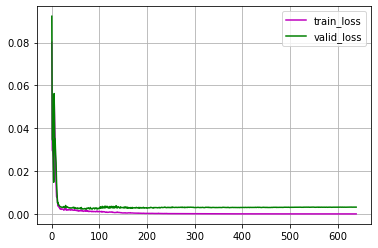

In [93]:
MAPE, MAE, RMSE, load_pred, load_true = run_model_retraining()
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

In [27]:
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

MAPE:0.0384057963665871, MAE:501.0451122660703, RMSE:738.5504601430696


## figure plot

(0.0, 19463.686996387154)

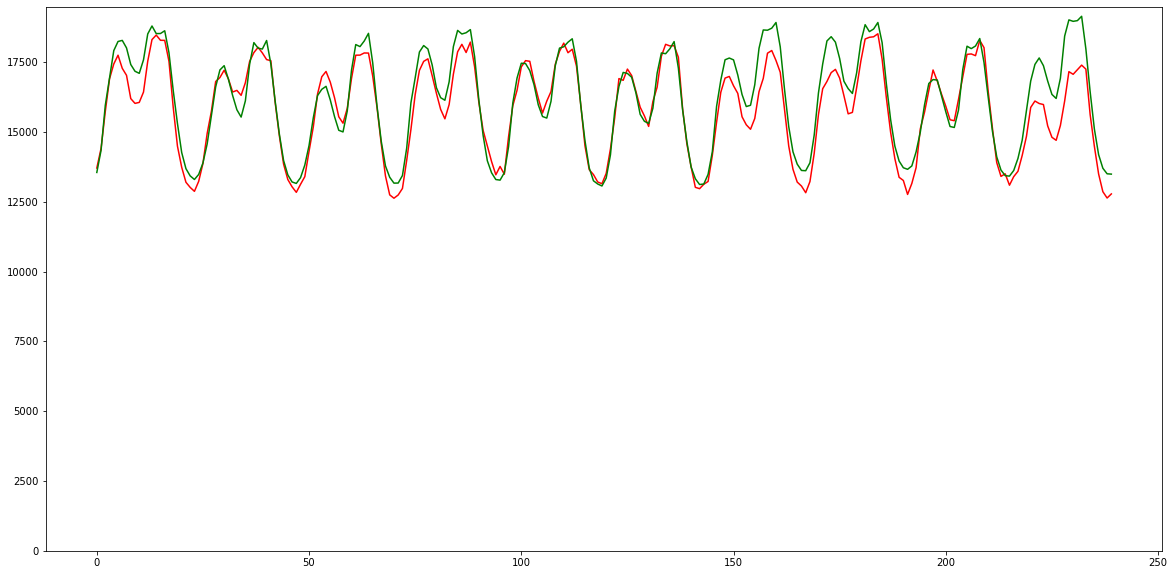

In [87]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, target_len)
load_true = load_true.reshape(-1, target_len)
plt.plot(load_pred[:240,0], 'r')
plt.plot(load_true[:240,0], 'g')
plt.ylim(0)